In [294]:
import os

import pytz
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn import cluster
from random import randint

In [295]:
path_data = "../../data"

filename_entete = "entete.csv"

# équivalent à path_data + filename_meteo et s'assure que le path est de la bonne forme
path_data_entete = os.path.join(path_data, filename_entete)
# affiche le chemin path_data_meteo
print(path_data_entete)

../../data/entete.csv


In [296]:
df_entete = pd.read_csv(path_data_entete, sep=",")

df_entete = df_entete.loc[
    df_entete["TypCde"] == "C"
]

df_entete["DateCreation"] = df_entete["DateCreation"].astype('datetime64')

df_entete = df_entete[{"CodeClient", "DateCreation"}].sort_values(['CodeClient', 'DateCreation'])

df_entete

,CodeClient,DateCreation
4363,1,2018-05-31
4364,1,2018-05-31
12045,1,2018-11-12
40737,1,2020-07-30
39220,1,2020-09-10
...,...,...
72832,14727,2022-04-06
72525,14734,2022-04-07
73029,14738,2022-04-05
73776,14750,2022-04-13


In [297]:
df_entete.dtypes

CodeClient               int64
DateCreation    datetime64[ns]
dtype: object

In [298]:
df_duplicates = df_entete.drop_duplicates(subset=['CodeClient'], keep=False)

df_duplicates["DateCreation"] = pd.to_datetime('2022-04-19')

df_entete = df_entete.append(df_duplicates)

df_entete['DateCreation'].apply(lambda x: x.replace(tzinfo=None))

df_entete

/var/folders/36/43f3rdln6_jby4rr0llzz6yh0000gn/T/ipykernel_23311/3077096763.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_duplicates["DateCreation"] = pd.to_datetime('2022-04-19')


,CodeClient,DateCreation
4363,1,2018-05-31
4364,1,2018-05-31
12045,1,2018-11-12
40737,1,2020-07-30
39220,1,2020-09-10
...,...,...
72832,14727,2022-04-19
72525,14734,2022-04-19
73029,14738,2022-04-19
73776,14750,2022-04-19


In [299]:
df_frequence = df_entete.groupby("CodeClient").apply(lambda x: x["DateCreation"].diff().astype('timedelta64[D]', errors='ignore').mean(skipna=True)).reset_index()

df_frequence.columns = ["CodeClient", "Frequence"]

df_frequence

,CodeClient,Frequence
0,1,123.909091
1,3,100.857143
2,12,370.000000
3,13,708.000000
4,22,1310.000000
...,...,...
2819,14727,13.000000
2820,14734,12.000000
2821,14738,14.000000
2822,14750,6.000000


In [300]:
df_frequence_bins = df_frequence['Frequence'].value_counts(bins = [0, 30, 90, 180, 365, 999999999]).reset_index().rename(columns={'index': 'Frequences', 'Frequence': 'Nombre'}).sort_values(["Frequences"])

df_frequence_bins['Frequences'] = [(round(x.left), round(x.right)) for x in df_frequence_bins['Frequences']]

df_frequence_bins

,Frequences,Nombre
4,"(0, 30)",172
3,"(30, 90)",411
2,"(90, 180)",566
1,"(180, 365)",589
0,"(365, 999999999)",1086


In [301]:
df_ca = pd.read_csv(path_data_entete, sep=",")

df_ca = df_ca .loc[
    df_ca ["TypCde"] == "C"
]

df_ca  = df_ca [{"CodeClient", "CAHT"}]

df_ca

,CodeClient,CAHT
0,2625,2065.80
1,5505,16960.51
4,10497,1748.40
8,10721,17951.01
10,1826,2083.47
...,...,...
73982,1775,0.00
73986,10487,0.00
73990,2162,0.00
73994,1378,0.00


In [302]:
df_ca = df_ca.groupby("CodeClient")["CAHT"].sum().reset_index()

df_ca

,CodeClient,CAHT
0,1,5008.42
1,3,31904.05
2,12,2889.90
3,13,1135.78
4,22,2253.28
...,...,...
2819,14727,1384.46
2820,14734,5458.58
2821,14738,460.34
2822,14750,0.00


In [303]:
df_ca_bins = df_ca['CAHT'].value_counts(bins = [0, 500, 1000, 5000, 20000, 999999999]).reset_index().rename(columns={'index': 'CAHTs', 'CAHT': 'Nombre'}).sort_values(["CAHTs"])

df_ca_bins['CAHTs'] = [(round(x.left), round(x.right)) for x in df_ca_bins['CAHTs']]

df_ca_bins

,CAHTs,Nombre
3,"(0, 500)",346
2,"(500, 1000)",468
0,"(1000, 5000)",1163
1,"(5000, 20000)",613
4,"(20000, 999999999)",234


# GRAPHIQUES

<AxesSubplot:xlabel='Frequences'>

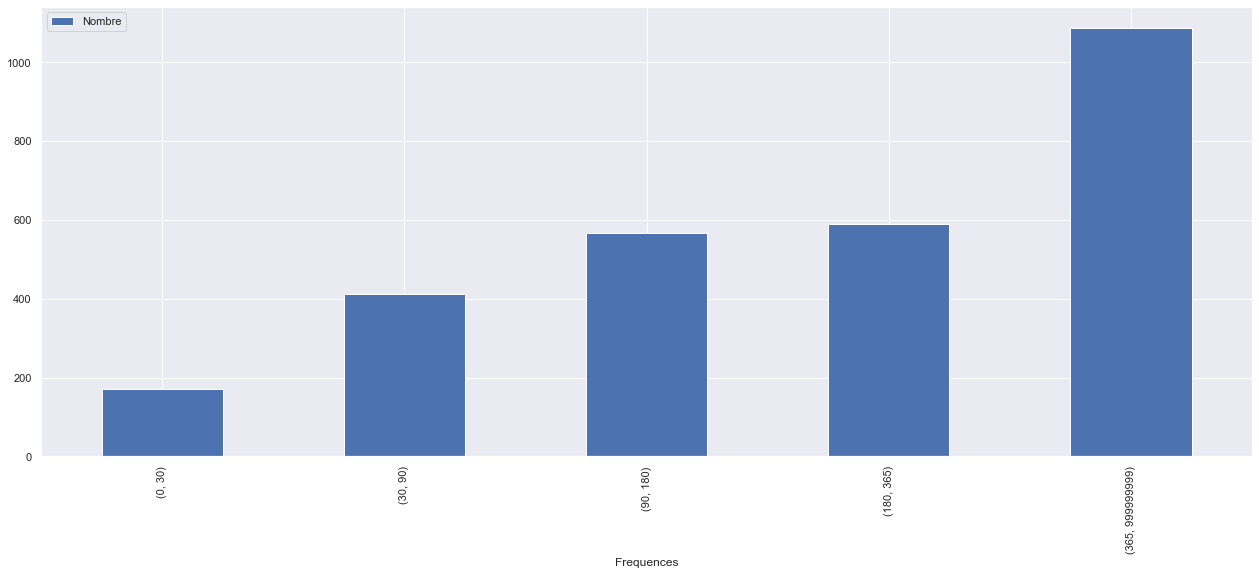

In [304]:
df_frequence_bins.plot(x="Frequences", y="Nombre", kind="bar")

<AxesSubplot:xlabel='CAHTs'>

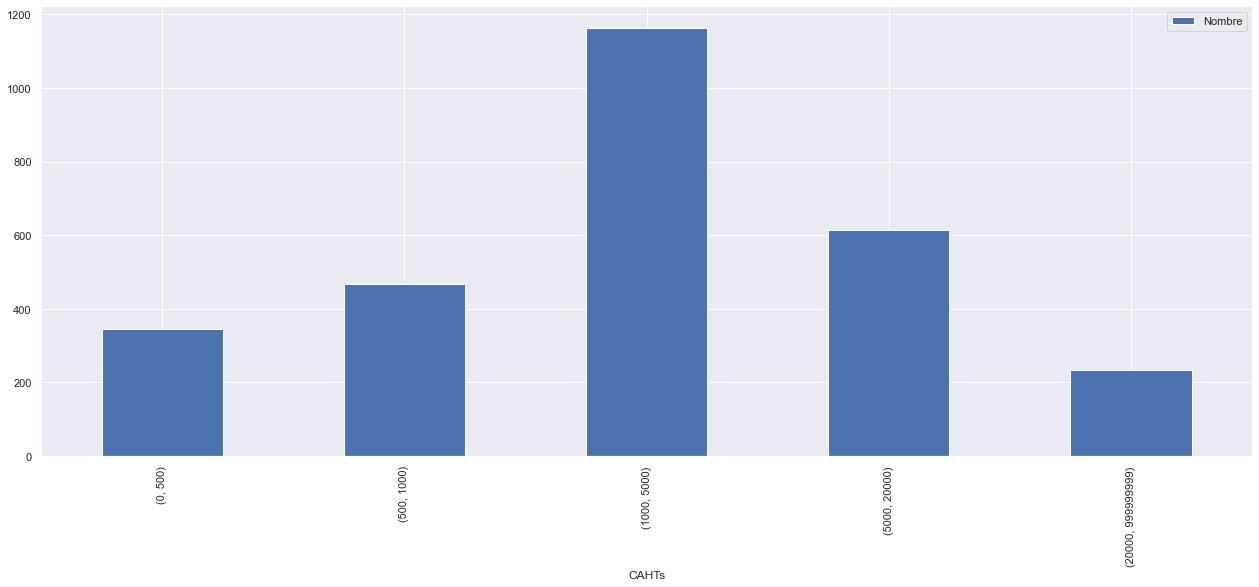

In [305]:
df_ca_bins.plot(x="CAHTs", y="Nombre", kind="bar")

In [306]:
df_matrix = pd.merge(df_frequence, df_ca, how="inner", on="CodeClient")

df_matrix

,CodeClient,Frequence,CAHT
0,1,123.909091,5008.42
1,3,100.857143,31904.05
2,12,370.000000,2889.90
3,13,708.000000,1135.78
4,22,1310.000000,2253.28
...,...,...,...
2819,14727,13.000000,1384.46
2820,14734,12.000000,5458.58
2821,14738,14.000000,460.34
2822,14750,6.000000,0.00


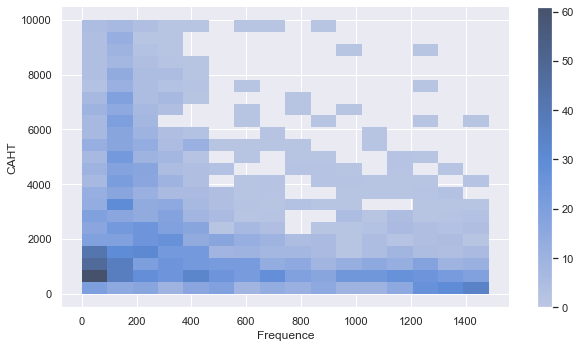

In [307]:
df_lowCAHT = df_matrix.loc[
    df_matrix["CAHT"] < 10000
]

sns.displot(df_lowCAHT, x="Frequence", y="CAHT", cbar=True, height=5, aspect=16/9)

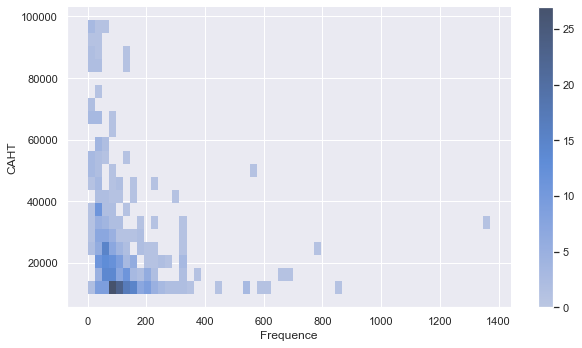

In [308]:
df_highCAHT = df_matrix.loc[
    (df_matrix["CAHT"] >= 10000) & (df_matrix["CAHT"] < 100000)
]

sns.displot(df_highCAHT, x="Frequence", y="CAHT", cbar=True, height=5, aspect=16/9)

In [309]:
sns.set(rc={})